<a href="https://colab.research.google.com/github/muhammedadhilp/reccomendation_engine/blob/main/reccomendation_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib

In [3]:
e_df = pd.read_csv('/content/ratings_Electronics (1).csv',names=['user_id','product_id','ratings','timestamp'])
e_df.head()

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [4]:
#  lets start eda
e_df.shape #  checking the shape of the dataframe
print('*'*10)
e_df.isna().sum() #  checking for missing values
print('*'*10)
e_df.info() #  printing basic info

(129174, 4)

**********


user_id       0
product_id    0
ratings       1
timestamp     1
dtype: int64

**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129174 entries, 0 to 129173
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     129174 non-null  object 
 1   product_id  129174 non-null  object 
 2   ratings     129173 non-null  float64
 3   timestamp   129173 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.9+ MB


In [5]:
# there seems to be 1 missing values in ratings and timestamp lets fill it with mean
e_df['ratings'] = e_df['ratings'].fillna(e_df['ratings'].mean())
e_df['timestamp'] = e_df['timestamp'].fillna(e_df['timestamp'].mean())

In [6]:
# since we are mainly concerned with ratings lets describe ratings
e_df.describe()['ratings'].T

count    129174.000000
mean          4.035495
std           1.353861
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: ratings, dtype: float64

In [7]:
# lets check the min and max ratings
print(f'Minimum rating is: {e_df.ratings.min()}')
print(f'Maximum rating is: {e_df.ratings.max()}')

Minimum rating is: 1.0
Maximum rating is: 5.0


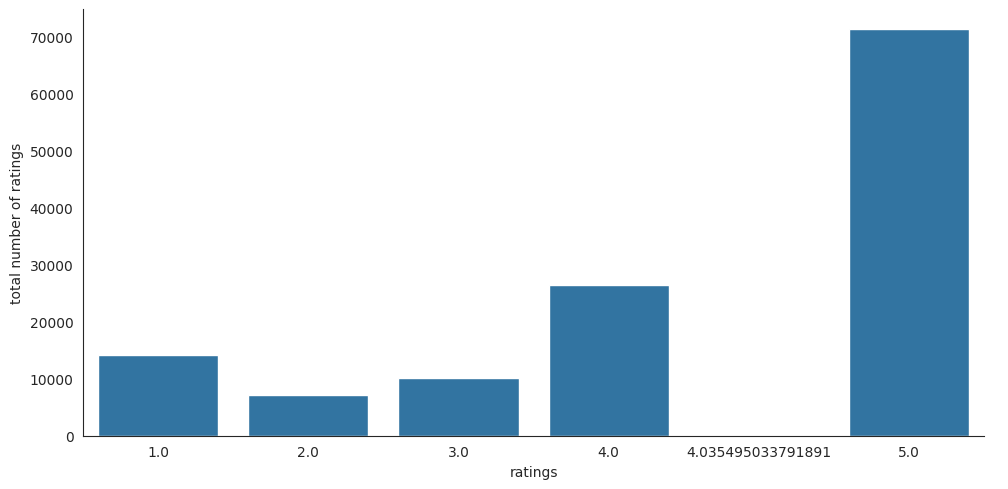

In [8]:
# checking hte distribution of the ratings
with sns.axes_style('white'):
  cp = sns.catplot(x='ratings',data= e_df,kind= 'count',aspect=2.0)
  cp.set_ylabels('total number of ratings')

In [9]:
#lets find total number of unigue users and products
print(f'Total number of unique users: {e_df.user_id.nunique()}') #nunique is a function associated with series/dataframes of pandas which can be used to easily find count of unique values
print(f'Total number of unique products: {e_df.product_id.nunique()}')

Total number of unique users: 114618
Total number of unique products: 8630


In [10]:
# since we don not need timestamp column we can drop it
e_df.drop(['timestamp'],axis=1,inplace=True)
e_df

,user_id,product_id,ratings
0,AKM1MP6P0OYPR,0132793040,5.000000
1,A2CX7LUOHB2NDG,0321732944,5.000000
2,A2NWSAGRHCP8N5,0439886341,1.000000
3,A2WNBOD3WNDNKT,0439886341,3.000000
4,A1GI0U4ZRJA8WN,0439886341,1.000000
...,...,...,...
129169,A2H2D8YO1JD7I6,B00005Y3V6,3.000000
129170,A1L2GJ4PY7D0C9,B00005Y3V6,5.000000
129171,A32U9P2JLUI9PP,B00005Y3V6,4.000000
129172,A1PLUQFZM2UR00,B00005Y3V6,5.000000


In [11]:
# Analysing the rating
no_of_products_per_user = e_df.groupby(by='user_id')['product_id'].count().sort_values(ascending=False)
no_of_products_per_user.info()

<class 'pandas.core.series.Series'>
Index: 114618 entries, A231WM2Z2JL0U3 to A2W4N97FK893WA
Series name: product_id
Non-Null Count   Dtype
--------------   -----
114618 non-null  int64
dtypes: int64(1)
memory usage: 1.7+ MB


In [12]:
no_of_products_per_user.describe()

count    114618.000000
mean          1.126996
std           0.831196
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         145.000000
Name: product_id, dtype: float64

In [13]:
quantile = no_of_products_per_user.quantile(np.arange(0,1.01,0.01),interpolation = "higher")
print(quantile)

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      2
0.97      2
0.98      3
0.99      3
1.00    145
Name: product_id, Length: 101, dtype: int64


<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their values')

<Axes: title={'center': 'Quantiles and their values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

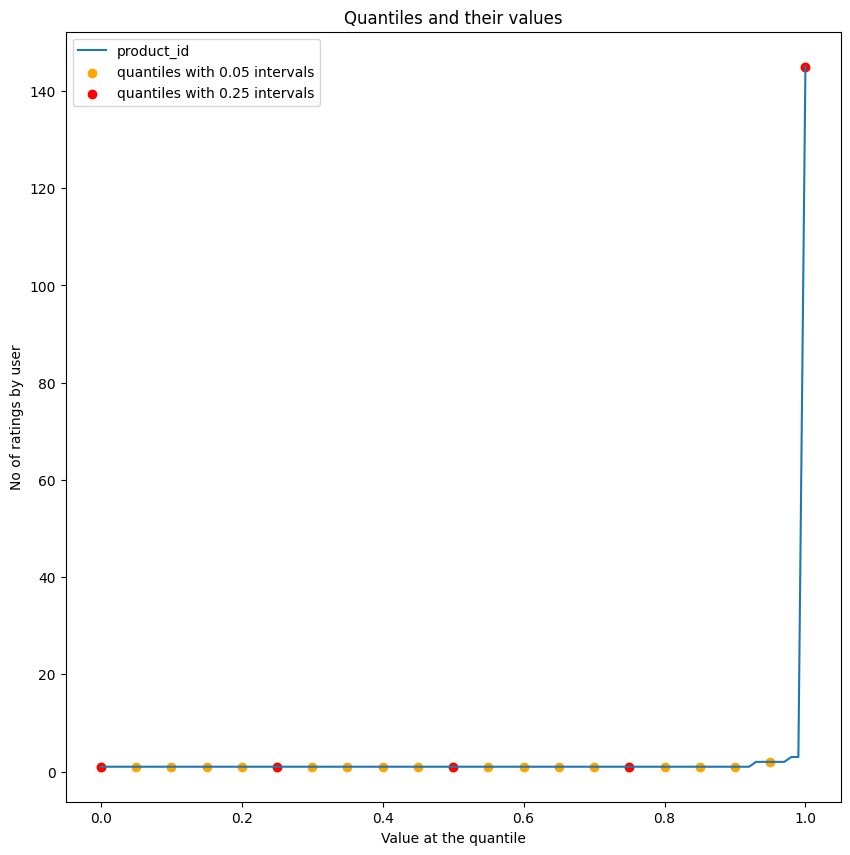

In [14]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their values")
quantile.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantile.index[::5], y=quantile.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantile.index[::25], y=quantile.values[::25], c='red', label="quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [15]:
# most no of product rated by a single user can be found out by printing the first element in the series as the order is descending
no_of_products_per_user.head(1)

user_id
A231WM2Z2JL0U3    145
Name: product_id, dtype: int64

Now lets start implementing popularity based reccomendation system


In [16]:
p_df = e_df.groupby('product_id').filter(lambda x:x['ratings'].count()>=50)
p_df

,user_id,product_id,ratings
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0
...,...,...,...
129096,AME7GG0XR5OSZ,B00005Y3OM,3.0
129097,A3UT28AL5Z3JC4,B00005Y3OM,5.0
129098,A1D5LKMJVIS0YH,B00005Y3OM,5.0
129099,A2BHFADX4385UK,B00005Y3OM,4.0


In [17]:
no_of_ratings_per_product = p_df.groupby(by='product_id')['ratings'].count().sort_values(ascending= False)
no_of_ratings_per_product

product_id
B00004ZCJE    2547
B00001P4ZH    2075
B00004T8R2    1692
B00001WRSJ    1586
B00005N6KG    1296
              ... 
B00005ALB1      50
B000050NON      50
B00005QJCU      50
B00005NHH8      50
B00001OXQ9      50
Name: ratings, Length: 453, dtype: int64

In [19]:
p_rating_mean_count = p_df.groupby('product_id')['ratings'].agg(['mean','count']).reset_index()
p_rating_mean_count.columns=['product_id','ratings_mean','ratings_count']
p_rating_mean_count

,product_id,ratings_mean,ratings_count
0,0972683275,4.470980,1051
1,1400501466,3.560000,250
2,1400501520,4.243902,82
3,1400501776,3.884892,139
4,1400532620,3.684211,171
...,...,...,...
448,B00005V619,4.274510,51
449,B00005V8R8,4.404762,84
450,B00005Y1Z6,4.051546,97
451,B00005Y1Z7,3.555556,117


 now we have a table with product rating means and how many users reviewed them, now i am going to apply imdb weighted rating formula to it to negate the changes made by low no of ratings in the values of mean rating


In [23]:
# create a function to find the weighted rating
# eq = (v / (v + m) * R) + (m / (v + m) * C)
C = p_rating_mean_count['ratings_mean'].mean()
m = 50# min rating required for the filtering step
def weighted_rating(x,m=m,c=c):
  v = x['ratings_count']
  R = x['ratings_mean']
  return (v / (v + m) * R) + (m / (v + m) * C)

In [24]:
# now lets apply the above function to our dataframe
p_rating_mean_count['weighted_rating']=p_rating_mean_count.apply(weighted_rating,axis=1)
p_rating_mean_count

,product_id,ratings_mean,ratings_count,weighted_rating
0,0972683275,4.470980,1051,4.451671
1,1400501466,3.560000,250,3.640966
2,1400501520,4.243902,82,4.168863
3,1400501776,3.884892,139,3.927460
4,1400532620,3.684211,171,3.766018
...,...,...,...,...
448,B00005V619,4.274510,51,4.161286
449,B00005V8R8,4.404762,84,4.270820
450,B00005Y1Z6,4.051546,97,4.049591
451,B00005Y1Z7,3.555556,117,3.702335


now we have a dependable column which truly reflects the mean rating of the products .we can use weighted_rating column to sort and find the most popular products

In [26]:
popular_products = p_rating_mean_count[['product_id','weighted_rating']]
popular_products = popular_products.sort_values('weighted_rating',ascending= False)
popular_products
#now we have the list of products with popularity in reverse order

,product_id,weighted_rating
292,B000053HH5,4.741284
291,B000053HC5,4.737453
159,B00004TDLD,4.699610
208,B00004XOM3,4.686714
355,B00005LEN4,4.638971
...,...,...
69,B00000JII6,3.145037
240,B00004Z61H,3.096934
49,B00000J3UJ,3.027499
138,B00004RFB8,2.940088


now lets create a collaberative reccomendation system

In [32]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
# creating a user-item matrix
user_item_matrix = p_df.pivot(index='user_id',columns='product_id',values='ratings').fillna(0)
# creating the sparse matrix
sparse_matrix = csr_matrix(user_item_matrix)
# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=42)
user_factors = svd.fit_transform(sparse_matrix)
item_factors = svd.components_
# Reconstruct the ratings matrix
predicted_ratings = np.dot(user_factors, item_factors)

# Convert predicted ratings back to a DataFrame for easier manipulation
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)

# Function to get recommendations for a specific user
def recommend_products(user_id, num_recommendations=5):
    user_ratings = predicted_ratings_df.loc[user_id].sort_values(ascending=False)
    already_rated = p_df[p_df.user_id == user_id]['product_id'].values
    recommendations = user_ratings.index.difference(already_rated)
    return user_ratings[recommendations].head(num_recommendations)
# Get recommendations for user A1BKC6B7YHYTVV
print(recommend_products(user_id="A1BKC6B7YHYTVV"))

product_id
1400501466    0.000035
1400501520    0.000005
1400501776    0.000008
1400532620    0.000034
1400532655    0.004775
Name: A1BKC6B7YHYTVV, dtype: float64
